# Topic Modeling with Eugenics Articles

## Import Data

Get data from picklefiles and store in DataFrame

In [1]:
import pickle
import pandas as pd 
import os

dicts = []
folders = ['equarterly_clean_articles/', 'ereview_clean_articles/', 'socbio_clean_articles/']
for folder in folders:
    filenames = os.listdir(folder)
    for file in filenames:
        infile = open(folder + file,'rb')
        corp_dict = pickle.load(infile)
        dicts.append(corp_dict)
        infile.close
    
df = pd.DataFrame(dicts)

df['title'] = df['title'].str.lower()
df['content'] = df['content'].str.lower()
df['year'] = pd.to_numeric(df['year'])
df

,title,year,publisher,content,has_ref,references,start_page,end_num
0,meetings and recent publications,1961,Eugenics Quarterly,organization reports: association for the ai...,False,,171,NaN
1,notes at the conclusion of the second princeto...,1966,Eugenics Quarterly,"the purpose of this meeting, as i understand...",False,,147,NaN
2,discussions on the teaching of genetics to med...,1961,Eugenics Quarterly,i n october 1961 at the rockefeller instit...,False,,223,NaN
3,a return to the principles of natural selection,1960,Eugenics Quarterly,editor's note: it is generally agreed that m...,False,,204,NaN
4,color blindness among korean students,1967,Eugenics Quarterly,introduction sexlinked defects in color visi...,True,"KALMUS, HANS, 1965 . Diagnosis and Genetics ...",271,NaN
...,...,...,...,...,...,...,...,...
2404,menopause in mothers of multiple births and mo...,1978,Social Biology,menopause in mothers of multiple births and m...,True,The design of the study and the development o...,52,NaN
2405,some considerations in the methodology of huma...,1973,Social Biology,some considerations in the methodology of hum...,True,"Atvin, P. 1967 . The testes, p. 395 445 . In...",241,NaN
2406,the estimation of natural fertility: a micro a...,1984,Social Biology,the estimation of natural fertility: a micro ...,True,We are grateful for assistance to Ramesh Amat...,160,NaN
2407,race of parents and infant birthweight in the ...,1991,Social Biology,14 mangold and powell griner a genetic compo...,True,An earlier version of this paper was presente...,13,NaN


## ***Tokenize with NLTK and Spacey***
### In general, there are two levels of tokenization: sentence level and word level.

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zeke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    tok = []
    tokens = parser(text)
    for token in tokens:
        if not token.orth_.isalpha() :
            continue
        else:
            tok.append(token.lower_)
    return tok

In [4]:
from nltk.tokenize import sent_tokenize

In [5]:
import random

random.seed(42)

df["token"] = df['content'].apply(sent_tokenize)

def word_tok(sentances):
    new_sents = []
    for sent in sentances:
        test = random.random()
        if test > 0.5:
            new_sents.append(tokenize(sent))
    
    return new_sents

df["token"] = df['token'].apply(word_tok)

df['token']


0       [[so, far, as, population, problems, are, conc...
1       [[we, may, be, approaching, the, problem, of, ...
2       [[invited, participants, represented, medical,...
3       [[editor, note, it, is, generally, agreed, tha...
4       [[areas, investigated, and, sample, size, in, ...
                              ...                        
2404    [[the, prevalence, of, operative, menopause, w...
2405    [[nevertheless, complex, characters, that, now...
2406    [[the, results, suggest, that, the, present, a...
2407    [[mangold, and, powell, griner, a, genetic, co...
2408    [[i, should, like, to, comment, on, both, prem...
Name: token, Length: 2409, dtype: object

# ***Stemming with NLTK***

#### The concept of stemming is a standardized method. Except for tense, many variations of words have the same meaning. To understand stem technique, consider the following:

- #### ***I like writing python code in a pythonic way.***
- #### ***I like pythoning pythonic python code.***

#### As you may see, although the two sentence vary in terms of using ***python***, however, the stem of the two sentences is the same: **python**

In [6]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [7]:
# def stem_list(sentances):
#     new_sents = []
#     for sent in sentances:
#         new_words = []
#         for word in sent:
#             new_words.append(ps.stem(word))

#         new_sents.append(new_words)

#     return new_sents

# df['token'] = df['token'].apply(stem_list)

# df['token']

# ***Lemmatizing with NLTK***

#### An operation very similar to stemming is called lemmatizing. The main difference between the two is that, stemming can create non-existent vocabulary.Let's look at some examples.

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lem_list(sentances):
    new_sents = []
    for sent in sentances:
        new_words = []
        for word in sent:
            new_words.append(lemmatizer.lemmatize(word))
    
        new_sents.append(new_words)
    
    return new_sents

df['token'] = df['token'].apply(lem_list)

[nltk_data] Downloading package wordnet to /Users/zeke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ***Stop words removal with NLTK***

#### The process of converting data into something the computer can understand is called pre-processing. One of the main forms of preprocessing is to filter out *useless* data. In NLP, the useless words (data) are called **stop words**.

#### The key assumption behinds this is: ***Some words are more meaningful than others***.

In [9]:
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zeke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop(tokens):
    stop_words = set(stopwords.words('english'))
    stop_words.add('wa')
    stop_words.add('ha')
    new_tokens = []
    for sentance in tokens:
        new_tokens.append([w for w in sentance if not w in stop_words])
        
    return new_tokens

df['token'] = df['token'].apply(remove_stop)

df['token']

0       [[far, population, problem, concerned, point, ...
1       [[may, approaching, problem, measuring, wrong,...
2       [[invited, participant, represented, medical, ...
3       [[editor, note, generally, agreed, much, resea...
4       [[area, investigated, sample, size, population...
                              ...                        
2404    [[prevalence, operative, menopause, slightly, ...
2405    [[nevertheless, complex, character, appear, un...
2406    [[result, suggest, present, approach, yield, p...
2407    [[mangold, powell, griner, genetic, component,...
2408    [[like, comment, premise, argument], [sex, rat...
Name: token, Length: 2409, dtype: object

# **Topic Modeling With LDA**

In [57]:
from gensim import corpora
import gensim
import pyLDAvis.gensim

def get_tokens(df):
    for index, row in df.iterrows():
        for token in row['token']:
            yield token
            
def topic_model(df, num_topics):
    text_data = list(get_tokens(df))
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
    lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    
    return ldamodel, lda_display


model = []
display = []
for i in range(1910, 2000, 10):
    new_model, new_display = topic_model(df[(df['year'] > i) & (df['year'] < i+10 )], 6)
    model.append(new_model)
    display.append(new_display)
    
pyLDAvis.display(display[1])

## Word Cloud Visualization

In [69]:
pyLDAvis.display(display[7])

word cloud for decades by LDA topic importance: 
Decade: 1910s


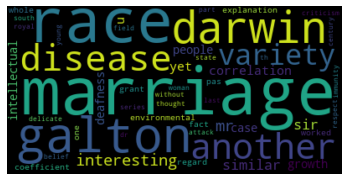

Decade: 1920s


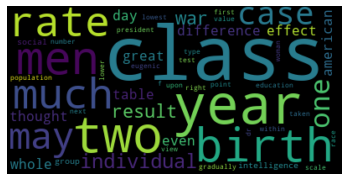

Decade: 1930s


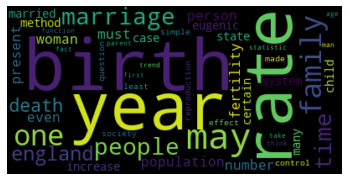

Decade: 1940s


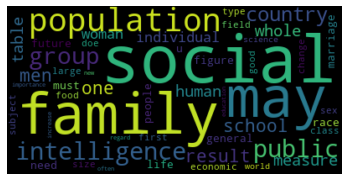

Decade: 1950s


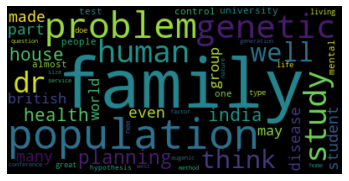

Decade: 1960s


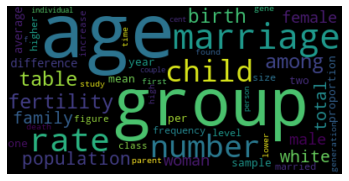

Decade: 1970s


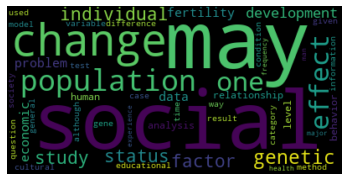

Decade: 1980s


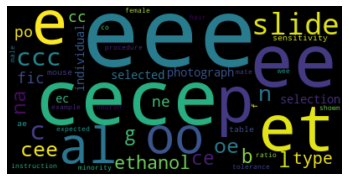

word cloud for decades by pure word frequency: 
Decade: 1910s


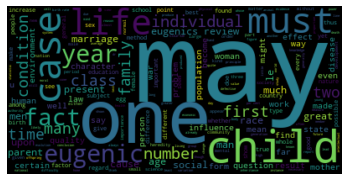

Decade: 1920s


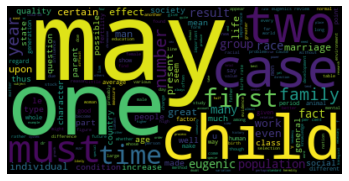

Decade: 1930s


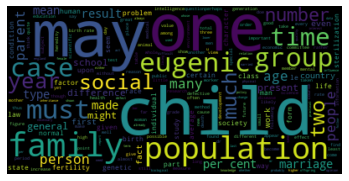

Decade: 1940s


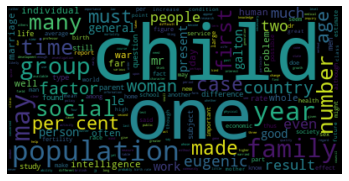

Decade: 1950s


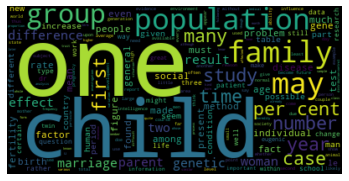

Decade: 1960s


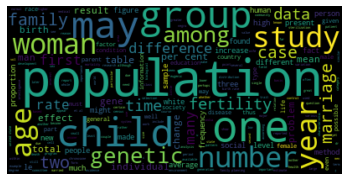

Decade: 1970s


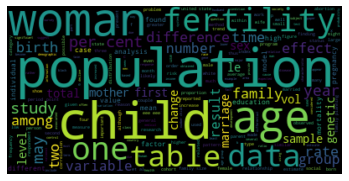

Decade: 1980s


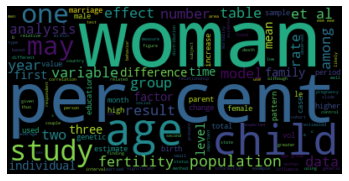

Decade: 1990s


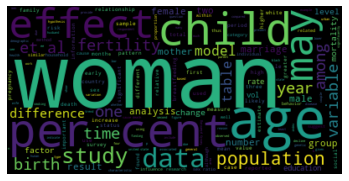

In [71]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

def get_words(df):
    for token in get_tokens(df):
        for word in token:
            yield word
            
print("word cloud for decades by LDA topic importance: ")
for i in range(8):
    print("Decade: {}s".format(i*10 + 1910))
    topics = model[i].print_topics(num_words=50)
    topics = topics[0][1].split('+')

    topic_dict = {}
    for topic in topics:
        word = topic.split('*')
        freq = float(word[0].strip())
        word = word[1].strip().strip('"')
        if word not in topic_dict.keys():
            topic_dict[word] = int(freq * 1000)
        else:
            topic_dict[word] += int(freq *1000)

    text = " ".join([(k + " ")*v for k,v in topic_dict.items()])

    text = text.replace("  ", " ")

    wordcloud = WordCloud(collocations = False).generate(text)

    _ = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis("off")
    _ = plt.show()
    
    
print("word cloud for decades by pure word frequency: ")
for i in range(1910, 2000, 10):
    print("Decade: {}s".format(i))
    text = " ".join(get_words(df[(df['year']>=i) & (df['year']<i+10)]))
    wordcloud = WordCloud().generate(text)

    _ = plt.imshow(wordcloud, interpolation='bilinear')
    _ = plt.axis("off")
    _ = plt.show()

